In [188]:
#packages to import
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string
import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.models import Sequential
from keras.initializers import Constant
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [2]:
#Load Training Data 
df = pd.read_csv("Full_sentiment_dataset.csv",encoding='latin-1', header =None,names= ["headline","topic","drop","sentiment"],index_col=False)
df = df.drop('drop', axis=1)   
df=df.drop([4345])             #Removed once bad sample
df.head()

,headline,topic,sentiment
0,Michael Bennet Drops Out of the 2020 President...,Bennet,neutral
1,Bennet Ends 2020 Bid After Poor Showing in New...,Bennet,negative
2,Brad Parscale on Joe Biden leaving New Hampshi...,Biden,negative
3,Dana Perino on Joe Biden's decision to abandon...,Biden,neutral
4,Chris Wallace: Biden is 'mortally wounded' if ...,Biden,negative


In [27]:
#Load testing Data and remove unnecessary columns
df_test = pd.read_csv("News_Final.csv")
df_test = df_test.drop(['IDLink','Facebook','GooglePlus','LinkedIn'], axis=1)
df_test.head()

,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline
0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300
1,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386
2,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754
3,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064
4,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084


Text(0, 0.5, 'Number of Articles')

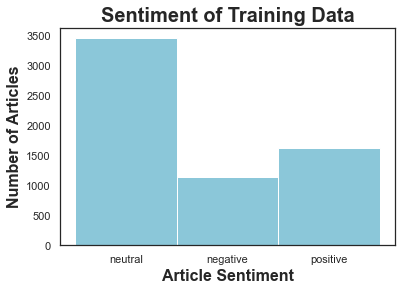

In [20]:
#Histogram of training data
sns.set_style("white")
sns.histplot(df["sentiment"], color = "c")
plt.title('Sentiment of Training Data', weight="bold",size=20)
plt.xlabel('Article Sentiment' ,weight="bold",size=16)
plt.ylabel('Number of Articles',weight="bold",size=16)

In [28]:
#Get root words
lemmatizer = WordNetLemmatizer()
stopwords   = set(nltk.corpus.stopwords.words('english'))
punctuation = string.punctuation

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
    
def normalize(text):
    for token in nltk.word_tokenize(text):
        token = token.lower()
        token = lemmatizer.lemmatize(token)
        if token not in stopwords and token not in punctuation:
            if token.isalpha():
                yield token

In [29]:
df["clean_headlines"] = ""
for text in enumerate(df["headline"]):
    ind  = text[0]
    text = text[1]
    root_text = ' '.join(list(normalize(text)))
    df["clean_headlines"][ind]=root_text
df.head()

,headline,topic,sentiment,clean_headlines
0,Michael Bennet Drops Out of the 2020 President...,Bennet,neutral,michael bennet drop presidential race
1,Bennet Ends 2020 Bid After Poor Showing in New...,Bennet,negative,bennet end bid poor showing new hampshire
2,Brad Parscale on Joe Biden leaving New Hampshi...,Biden,negative,brad parscale joe biden leaving new hampshire ...
3,Dana Perino on Joe Biden's decision to abandon...,Biden,neutral,dana perino joe biden decision abandon new ham...
4,Chris Wallace: Biden is 'mortally wounded' if ...,Biden,negative,chris wallace biden wounded ha bad result new ...


In [322]:
num=49
print(df["headline"][num])
print(df["clean_headlines"][num])

In Iowaâs Small Black Community, Little Love for the Caucuses or Joe Biden
small black community little love caucus joe biden


In [153]:
#Create train test split
y = df["sentiment"]
x = df["clean_headlines"]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=23)

In [32]:
print("X train shape",X_train.shape[0])
print("X test shape",X_test.shape[0])
print("X shape",x.shape[0])
print("y shape",y.shape[0])

X train shape 4655
X test shape 1552
X shape 6207
y shape 6207


100%|██████████| 6207/6207 [00:00<00:00, 6415.44it/s]


<AxesSubplot:ylabel='Count'>

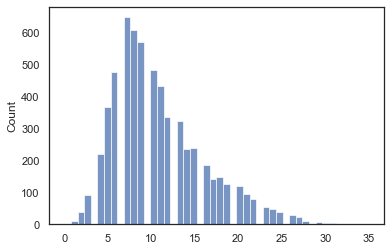

In [33]:
def create_corpus(df):
    corpus=[]
    for headline in tqdm(x):
        words=[word.lower() for word in word_tokenize(headline) if((word.isalpha()==1) & (word not in stopwords))]
        corpus.append(words)
    return corpus
corpus=create_corpus(x)
maxlen=[]
for headline in corpus:
    maxlen.append(len(headline))
sns.histplot(maxlen)

In [34]:
#Example of lemmatization
print(X_train[3003])
print(list(normalize(X_train[3003])))

number customer one important parameter determining price electricity network
['number', 'customer', 'one', 'important', 'parameter', 'determining', 'price', 'electricity', 'network']


In [154]:
#TFIDF Vectorizer 
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
x_test_tfidf = vectorizer.transform(X_test)

In [36]:
#Word2Vec Transformation

import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')
word2vec.vector_size

300

In [37]:
#Example  that word2vec works
word2vec.most_similar("truck")

[('pickup_truck', 0.7816603183746338),
 ('trucks', 0.7529183626174927),
 ('dump_truck', 0.744109570980072),
 ('tractor_trailer', 0.7255718111991882),
 ('van', 0.7252801656723022),
 ('vehicle', 0.702707052230835),
 ('tanker_truck', 0.6915155053138733),
 ('tractor', 0.6907906532287598),
 ('Peterbilt_truck', 0.6825098991394043),
 ('car', 0.6735789775848389)]

In [38]:
# remove out-of-vocabulary words
# Use normalize to make a list of lematized words from headline 
def document_vector(word2vec_model, headline):
    headline_lst = list(normalize(headline))
    headline     = [word for word in headline_lst if word in word2vec.key_to_index]
    return np.mean(word2vec_model[headline], axis=0)

In [247]:
#Transform all headlines into an averaged vector
headlines_w2v =[]
count=0
for headline in df["headline"]:
    if len(headline)>0:
        headlines_w2v.append (document_vector (word2vec, headline))
        count+=1
    else:
        print(count)
headlines_w2v = np.array(headlines_w2v)

In [227]:
X_train_wv, X_test_wv, y_train, y_test = train_test_split(headlines_w2v, y, random_state=23)

#SVM Model

In [155]:
svm = SVC(kernel = 'linear', C = 1)
svm.fit(X_train_tfidf, y_train)
pred_train = svm.predict(X_train_tfidf)
pred_test  = svm.predict(x_test_tfidf)
print("Training set Metrics")
print(metrics.classification_report(y_train, pred_train))
print("Test set Metrics")
print(metrics.classification_report(y_test, pred_test))
print("Validation set Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred_test))

Training set Metrics
              precision    recall  f1-score   support

    negative       0.87      0.74      0.80       865
     neutral       0.85      0.97      0.90      2606
    positive       0.94      0.73      0.82      1184

    accuracy                           0.87      4655
   macro avg       0.88      0.81      0.84      4655
weighted avg       0.87      0.87      0.86      4655

Test set Metrics
              precision    recall  f1-score   support

    negative       0.54      0.38      0.45       272
     neutral       0.67      0.86      0.75       844
    positive       0.69      0.43      0.53       436

    accuracy                           0.66      1552
   macro avg       0.63      0.56      0.58      1552
weighted avg       0.65      0.66      0.64      1552

Validation set Confusion Matrix
[[104 146  22]
 [ 55 727  62]
 [ 34 214 188]]


In [43]:
svm = SVC()
params = dict(C= [0.1, 10, 50, 100], kernel = ['linear', 'poly', 'rbf', 'sigmoid'])
svm = GridSearchCV(estimator=svm, param_grid=params, n_jobs=-1)
svm.fit(X_train_tfidf, y_train)
svm.best_params_

{'C': 100, 'kernel': 'rbf'}

In [44]:
svm = SVC(kernel = 'rbf', C = 100)
svm.fit(X_train_tfidf, y_train)
pred_train = svm.predict(X_train_tfidf)
pred_test  = svm.predict(x_test_tfidf)
print("Training set Metrics")
print(metrics.classification_report(y_train, pred_train))
print("Test set Metrics")
print(metrics.classification_report(y_test, pred_test))
print("Validation set Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred_test))

Training set Metrics
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99       865
     neutral       1.00      1.00      1.00      2606
    positive       1.00      1.00      1.00      1184

    accuracy                           1.00      4655
   macro avg       1.00      1.00      1.00      4655
weighted avg       1.00      1.00      1.00      4655

Test set Metrics
              precision    recall  f1-score   support

    negative       0.52      0.34      0.41       272
     neutral       0.67      0.88      0.76       844
    positive       0.71      0.44      0.55       436

    accuracy                           0.66      1552
   macro avg       0.64      0.55      0.57      1552
weighted avg       0.66      0.66      0.64      1552

Validation set Confusion Matrix
[[ 92 149  31]
 [ 53 745  46]
 [ 32 211 193]]


SVM using word2vec embeddings

In [157]:
svm = SVC(kernel = 'linear', C = 1)
svm.fit(X_train_wv, y_train)
pred_train = svm.predict(X_train_wv)
pred_test  = svm.predict(X_test_wv)
print("Training set Metrics")
print(metrics.classification_report(y_train, pred_train))
print("Test set Metrics")
print(metrics.classification_report(y_test, pred_test))
print("Validation set Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred_test))

Training set Metrics
              precision    recall  f1-score   support

    negative       0.69      0.58      0.63       865
     neutral       0.74      0.89      0.81      2606
    positive       0.72      0.48      0.58      1184

    accuracy                           0.73      4655
   macro avg       0.72      0.65      0.67      4655
weighted avg       0.73      0.73      0.72      4655

Test set Metrics
              precision    recall  f1-score   support

    negative       0.59      0.51      0.55       272
     neutral       0.70      0.86      0.77       844
    positive       0.68      0.42      0.52       436

    accuracy                           0.68      1552
   macro avg       0.65      0.60      0.61      1552
weighted avg       0.67      0.68      0.66      1552

Validation set Confusion Matrix
[[140 104  28]
 [ 57 726  61]
 [ 40 211 185]]


In [323]:
svm = SVC()
params = dict(C= [0.1, 10, 50, 100], kernel = ['linear', 'poly', 'rbf', 'sigmoid'])
params = dict(C= [0.1, 10, 50, 100], degree = [1,2,3,4,5])
svm = GridSearchCV(estimator=svm, param_grid=params, n_jobs=-1)
svm.fit(X_train_tfidf, y_train)
svm.best_params_

{'C': 100, 'degree': 1}

In [325]:
svm = SVC(kernel = 'rbf', C = 100, degree=1,probability =True)
svm.fit(X_train_wv, y_train)
pred_train = svm.predict(X_train_wv)
pred_test  = svm.predict(X_test_wv)
print("Training set Metrics")
print(metrics.classification_report(y_train, pred_train))
print("Test set Metrics")
print(metrics.classification_report(y_test, pred_test))
print("Validation set Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred_test))

Training set Metrics
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99       865
     neutral       1.00      1.00      1.00      2606
    positive       1.00      0.99      1.00      1184

    accuracy                           1.00      4655
   macro avg       1.00      1.00      1.00      4655
weighted avg       1.00      1.00      1.00      4655

Test set Metrics
              precision    recall  f1-score   support

    negative       0.53      0.59      0.56       272
     neutral       0.75      0.78      0.77       844
    positive       0.66      0.55      0.60       436

    accuracy                           0.68      1552
   macro avg       0.64      0.64      0.64      1552
weighted avg       0.68      0.68      0.68      1552

Validation set Confusion Matrix
[[160  83  29]
 [ 86 662  96]
 [ 57 139 240]]


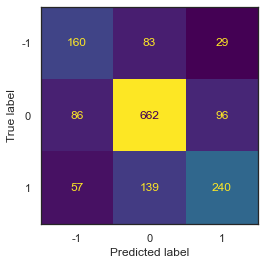

In [233]:
#Confusion matrix made pretty
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svm, X_test_wv, y_test,colorbar=False,display_labels=[-1,0,1])  
plt.show()

In [280]:
news_headlines=[]
count=0
for headline in df_test["Title"]:
    if len(headline)>0:
        count= count +1
        try:
            news_headlines.append (document_vector (word2vec, headline))
        except:
            news_headlines.append (np.zeros(300))

In [285]:
news_headlines=[]
df_test["lemmatized_headlines"] = ""
for headline in df_test["Title"]:
    if len(headline)>0:
        try:
            news_headlines.append (document_vector (word2vec, headline))
        except:
            news_headlines.append (np.zeros(300))

predic_sentiment = svm.predict(np.array(news_headlines))
df_test['Sentiment_Classification'] = predic_sentiment.tolist()
df_test.head()

,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,lemmatized_headlines,Sentiment_Classification
0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,,negative
1,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,,neutral
2,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,,neutral
3,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,,neutral
4,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,,neutral


In [292]:
for text in enumerate(df_test["Title"]):
    ind  = text[0]
    text = text[1]
    root_text = ' '.join(list(normalize(text)))
    df_test["lemmatized_headlines"][ind]=root_text
df_test.head()

,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,lemmatized_headlines,Sentiment_Classification
0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,obama lay wreath arlington national cemetery,negative
1,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,look health chinese economy,neutral
2,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,nouriel roubini global economy back,neutral
3,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,finland gdp expands,neutral
4,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,tourism govt spending buoy thai economy january,neutral


In [294]:
df_test.to_csv("sentiment_scores_news_headlines.csv")

In [53]:
#Random Forrest Classifier with word2vec embeddings
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_wv, y_train)
pred_train = rfc.predict(X_train_wv)
pred_test  = rfc.predict(X_test_wv)
print("Training set Metrics")
print(metrics.classification_report(y_train, pred_train))
print("Test set Metrics")
print(metrics.classification_report(y_test, pred_test))
print("Validation set Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred_test))

Training set Metrics
              precision    recall  f1-score   support

    negative       0.99      1.00      0.99       865
     neutral       1.00      1.00      1.00      2606
    positive       1.00      1.00      1.00      1184

    accuracy                           1.00      4655
   macro avg       1.00      1.00      1.00      4655
weighted avg       1.00      1.00      1.00      4655

Test set Metrics
              precision    recall  f1-score   support

    negative       0.50      0.22      0.30       272
     neutral       0.62      0.95      0.75       844
    positive       0.68      0.23      0.34       436

    accuracy                           0.62      1552
   macro avg       0.60      0.46      0.46      1552
weighted avg       0.62      0.62      0.56      1552

Validation set Confusion Matrix
[[ 59 179  34]
 [ 34 798  12]
 [ 25 311 100]]


In [332]:
rfc = RandomForestClassifier(n_estimators=100, random_state=23, max_depth = 5, min_samples_split= 25)
rfc.fit(X_train_wv, y_train)
pred_train = rfc.predict(X_train_wv)
pred_test  = rfc.predict(X_test_wv)
print("Training set Metrics")
print(metrics.classification_report(y_train, pred_train))
print("Test set Metrics")
print(metrics.classification_report(y_test, pred_test))
print("Validation set Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred_test))

Training set Metrics
              precision    recall  f1-score   support

    negative       0.87      0.11      0.19       865
     neutral       0.62      0.99      0.76      2606
    positive       0.64      0.20      0.30      1184

    accuracy                           0.62      4655
   macro avg       0.71      0.43      0.42      4655
weighted avg       0.67      0.62      0.54      4655

Test set Metrics
              precision    recall  f1-score   support

    negative       0.55      0.04      0.08       272
     neutral       0.58      0.98      0.73       844
    positive       0.56      0.14      0.23       436

    accuracy                           0.58      1552
   macro avg       0.56      0.39      0.35      1552
weighted avg       0.57      0.58      0.47      1552

Validation set Confusion Matrix
[[ 12 225  35]
 [  5 826  13]
 [  5 369  62]]


Neural Network

code modified from https://www.youtube.com/watch?v=8YsZXTpFRO0&list=PLD80i8An1OEHSai9cf-Ip-QReOVW76PlB&index=10&t=874s

In [200]:
#Helper Function
def neural_metrics(X_test,y_test):
    predictions= model.predict(X_test)
    matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
    print("Confusion Matrix")
    print(matrix)
    print("Test set Metrics")
    print(metrics.classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

In [164]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.preprocessing import text, sequence
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Bidirectional
encoder = LabelEncoder()
encoder.fit(y)
encoded_y =encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)
dummy_y

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [336]:
#Create train test split
x = df["clean_headlines"]
X_train, X_test, y_train, y_test = train_test_split(x,dummy_y,random_state=23)

In [337]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen = 20)
X_test  = sequence.pad_sequences(X_test , maxlen = 20)
vocabWords = len(tokenizer.word_index)+1

In [64]:
embeddings_index = dict()
f = open('glove.42B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs =np.asarray (values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close

<function TextIOWrapper.close()>

In [66]:
embedding_matrix = np.zeros((vocabWords,300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

(7970, 300)

In [65]:
print("Loaded %s word vectors." % len(embeddings_index))

Loaded 1917494 word vectors.


Confusion Matrix
[[106 129  37]
 [ 83 638 123]
 [ 49 197 190]]
Test set Metrics
              precision    recall  f1-score   support

           0       0.45      0.39      0.42       272
           1       0.66      0.76      0.71       844
           2       0.54      0.44      0.48       436

    accuracy                           0.60      1552
   macro avg       0.55      0.53      0.53      1552
weighted avg       0.59      0.60      0.59      1552

None


<AxesSubplot:>

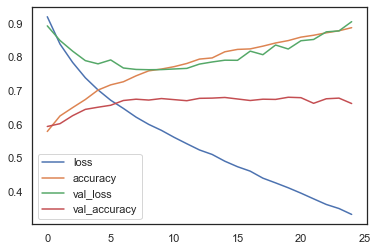

In [338]:
#CNN Model with learned embeddings
model = Sequential()
model.add(Embedding(vocabWords, 300, input_length = 20))
model.add(Dropout(0.5))
model.add(Conv1D(16,3,padding='valid',activation= 'relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(Conv1D(16,3,padding='valid',activation= 'relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(3, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#print(model.summary())

model.fit(X_train, y_train, batch_size = 10, epochs = 30, validation_data = (X_test, y_test),verbose=0)

print(neural_metrics(X_test,y_test))
pd.DataFrame(history.history).plot()

Confusion Matrix
[[ 62 179  31]
 [ 17 768  59]
 [ 16 234 186]]
Test set Metrics
              precision    recall  f1-score   support

           0       0.65      0.23      0.34       272
           1       0.65      0.91      0.76       844
           2       0.67      0.43      0.52       436

    accuracy                           0.65      1552
   macro avg       0.66      0.52      0.54      1552
weighted avg       0.66      0.65      0.62      1552

None


<AxesSubplot:>

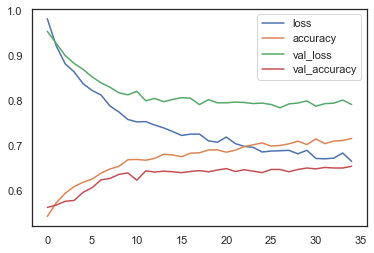

In [175]:
#CNN Model with Glove embeddings
model = Sequential()
model.add(Embedding(vocabWords, 300, input_length = 20, weights= [embedding_matrix], trainable = False))
model.add(Dropout(0.4))
model.add(Conv1D(16,2,padding='valid',activation= 'relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.4))
model.add(Conv1D(16,2,padding='valid',activation= 'relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(3, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#print(model.summary())

history = model.fit(X_train, y_train, batch_size = 15, epochs = 35, validation_data = (X_test, y_test),verbose= 0)

print(neural_metrics(X_test,y_test))
pd.DataFrame(history.history).plot()

Confusion Matrix
[[139 117  16]
 [ 84 683  77]
 [ 56 175 205]]
Test set Metrics
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       272
           1       0.70      0.81      0.75       844
           2       0.69      0.47      0.56       436

    accuracy                           0.66      1552
   macro avg       0.63      0.60      0.60      1552
weighted avg       0.66      0.66      0.65      1552

None


<AxesSubplot:>

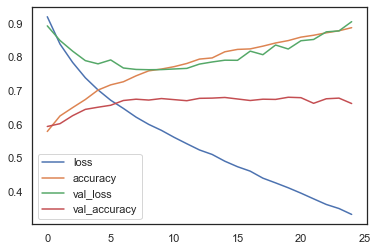

In [201]:
#LSTM Model with Glove Embeddings
model = Sequential()
model.add(Embedding(vocabWords, 300, input_length = 20, weights= [embedding_matrix], trainable = False))
#model.add(LSTM(20,activation ='sigmoid',return_sequences=True))   Removed due to overfitting
model.add(LSTM(20,activation ='sigmoid'))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

history = model.fit(X_train, y_train, batch_size = 10, epochs = 25, validation_data = (X_test, y_test),verbose = 0)
print(neural_metrics(X_test,y_test))
pd.DataFrame(history.history).plot()

Confusion Matrix
[[121 122  29]
 [ 63 691  90]
 [ 46 174 216]]
Test set Metrics
              precision    recall  f1-score   support

           0       0.53      0.44      0.48       272
           1       0.70      0.82      0.75       844
           2       0.64      0.50      0.56       436

    accuracy                           0.66      1552
   macro avg       0.62      0.59      0.60      1552
weighted avg       0.65      0.66      0.65      1552

None


<AxesSubplot:>

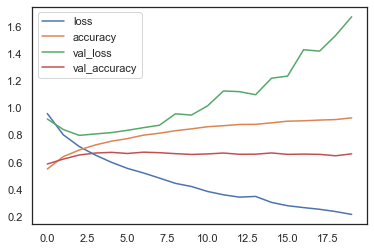

In [183]:
#Bidirectional LSTM Model
model = Sequential()
model.add(Embedding(vocabWords, 300, input_length = 20, weights= [embedding_matrix], trainable = False))
model.add(Bidirectional(LSTM(5,activation ='relu')))#,return_sequences=True)))
#model.add(LSTM(5,activation ='relu')) Removed due to overfitting
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#print(model.summary())

history = model.fit(X_train, y_train, batch_size = 10, epochs = 20, validation_data = (X_test, y_test),verbose = 0)
print(neural_metrics(X_test,y_test))
pd.DataFrame(history.history).plot()